In [19]:
## importing dependencies

import numpy as np
import pandas as pd
import os
import cv2
from glob import glob

import matplotlib.pyplot as plt

from tensorflow.keras.layers import BatchNormalization,Conv2D,Dense,Dropout,MaxPool2D,Flatten,AveragePooling2D,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [20]:
# defining the image size for modelling
IMAGE_SIZE=[256,256]

# path to the train and test directory
train_path = '/content/downloaded_images/train'
test_path = '/content/downloaded_images/test'

# getting all the images path from train, test directories respectively ..

train_files = glob(train_path + "/*/*.jpg")
test_files = glob(test_path + "/*/*.jpg")

## Data Augmentations and Data Splitting

In [21]:
# create an instance of the imagedatagenerator

gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    vertical_flip=True)

In [24]:
# train and test data generator

train_gen = gen.flow_from_directory('downloaded_images/train',target_size=IMAGE_SIZE,shuffle=True)
test_gen = gen.flow_from_directory('downloaded_images/test',target_size=IMAGE_SIZE,shuffle=True)

Found 303 images belonging to 3 classes.
Found 224 images belonging to 3 classes.


In [25]:
# the following directory gives the class indices

train_gen.class_indices

{'jeans': 0, 'saree': 1, 'trouser': 2}

## Model Building

In [26]:
# Importing the VGG 16 Model and its preprocessed Inputs

from tensorflow.keras.applications import VGG16 as Pretrained_Model
from tensorflow.keras.applications.vgg16 import preprocess_input

In [27]:
# setting weights

ptm = Pretrained_Model(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top =False)


# freezing the pretrained models
ptm.trainable = False

# map the data into feature vectors
# keras image data generators return one hot codded classes
x = Flatten()(ptm.output)
prediction = Dense(3,activation='softmax')(x)

# create a new model instance
model = tf.keras.models.Model(inputs=ptm.input,outputs=prediction)

In [28]:
# get the summary of the model

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [29]:
# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [30]:
# fitting the model

Early_Stopping = tf.keras.callbacks.EarlyStopping(verbose=3,patience=3)
model.fit(train_gen,epochs=10,
          validation_data=test_gen)

Epoch 1/10
10/10 [==============================] - 86s 9s/step - loss: 1.4519 - accuracy: 0.4785 - val_loss: 0.8594 - val_accuracy: 0.5804
Epoch 2/10
10/10 [==============================] - 93s 10s/step - loss: 0.4767 - accuracy: 0.7987 - val_loss: 0.6112 - val_accuracy: 0.6964
Epoch 3/10
10/10 [==============================] - 91s 9s/step - loss: 0.3090 - accuracy: 0.8779 - val_loss: 0.6597 - val_accuracy: 0.7321
Epoch 4/10
10/10 [==============================] - 89s 9s/step - loss: 0.2233 - accuracy: 0.9076 - val_loss: 0.5957 - val_accuracy: 0.7232
Epoch 5/10
10/10 [==============================] - 89s 9s/step - loss: 0.1842 - accuracy: 0.9307 - val_loss: 0.5800 - val_accuracy: 0.7232
Epoch 6/10
10/10 [==============================] - 91s 9s/step - loss: 0.1449 - accuracy: 0.9439 - val_loss: 0.5598 - val_accuracy: 0.7634
Epoch 7/10
10/10 [==============================] - 95s 10s/step - loss: 0.1924 - accuracy: 0.9109 - val_loss: 0.6097 - val_accuracy: 0.7545
Epoch 8/10
10/10 [

In [31]:
# create a dataframe to show the metrics per epoch

losses = pd.DataFrame(model.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,1.451856,0.478548,0.859441,0.580357
1,0.476710,0.798680,0.611216,0.696429
2,0.309006,0.877888,0.659703,0.732143
3,0.223275,0.907591,0.595666,0.723214
4,0.184182,0.930693,0.579979,0.723214
5,0.144857,0.943894,0.559775,0.763393
6,0.192413,0.910891,0.609652,0.754464
7,0.096585,0.973597,0.525307,0.794643
8,0.091577,0.973597,0.558059,0.781250
9,0.075703,0.976898,0.641084,0.736607


No handles with labels found to put in legend.


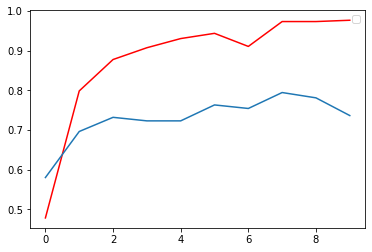

In [32]:
# plotting the accuracy of the model

plt.plot(losses['accuracy'],color='red')
plt.plot(losses['val_accuracy'])
plt.legend()

No handles with labels found to put in legend.


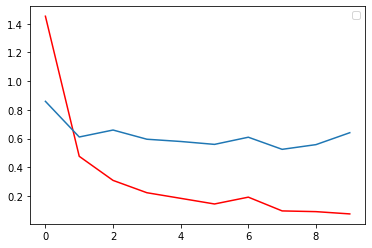

In [33]:
# plotting the lss of the model

plt.plot(losses['loss'],color='red')
plt.plot(losses['val_loss'])
plt.legend()

## Predicting on any random image

In [34]:
name_labels_df = pd.DataFrame(list(test_gen.class_indices.items()),columns = ['names','labels'],index=None)

In [35]:
name_labels_df

,names,labels
0,jeans,0
1,saree,1
2,trouser,2


In [71]:
#predicting any random image
import numpy as np
from keras.preprocessing import image

def predict_random_image():
    
    img = image.load_img(np.random.choice(test_path),target_size=IMAGE_SIZE)
    x = image.img_to_array(img)
    plt.imshow(img)
    x = np.expand_dims(x, axis=0) /255.0
    result_df = pd.DataFrame(list(model.predict(x)[0]),index=name_labels_df.names.values,columns=['result'])
    print(result_df.result.idxmax())

trousers


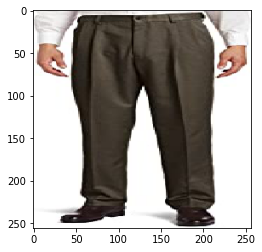

In [192]:
predict_random_image()

jeans


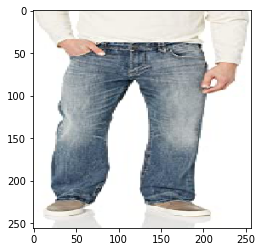

In [200]:
predict_random_image()

## Saving the model

In [73]:
# model artifact
model.save("image_classifier_model.h5")